In [ ]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/paper/ocular.zip' -d '/content/drive/MyDrive/paper/'

Archive:  /content/drive/MyDrive/paper/ocular.zip
  inflating: /content/drive/MyDrive/paper/dataset/cataract/0_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/103_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1062_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1083_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1084_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1102_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1102_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1115_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1126_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/112_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1144_left.jpg  
  inflating: /content/drive/MyDrive/paper/dataset/cataract/1144_right.jpg  
  inflating: /content/drive/MyDrive/paper/dataset

In [ ]:
train = '/content/drive/MyDrive/paper/dataset'
translate = {"normal": "normal", "cataract": "cataract", "diabetic_retinopathy": "diabetic_retinopathy", "glaucoma": "glaucoma"}
print("Animals & directory info: ")
dataset = []
for i in os.listdir('/content/drive/MyDrive/paper/dataset'):
    dataset.append(os.path.join(train , i))
for i in dataset:
    name = i.split('/')[-1]
    print(name , "is translated as" , translate[name] , "and folder length is" , len(os.listdir(i)))

Animals & directory info: 
cataract is translated as cataract and folder length is 1038
diabetic_retinopathy is translated as diabetic_retinopathy and folder length is 1098
glaucoma is translated as glaucoma and folder length is 1007
normal is translated as normal and folder length is 1074


In [ ]:
import cv2

image_array = []
image_label = []
for i in dataset:
    for n , j in enumerate(os.listdir(i)):
        if(n<1001):
            img_path = os.path.join(i , j)
            e = cv2.resize(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB),(224,224))
            image_array.append(e)
            l = i.split('/')[-1]
            image_label.append(translate[l])

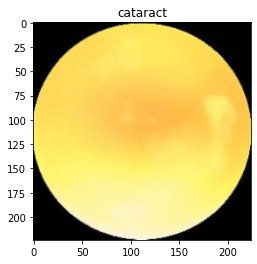

In [ ]:
plt.imshow(image_array[900])
plt.title(image_label[900])
plt.show()

In [ ]:
import pandas as pd
image_label = pd.get_dummies(image_label).values
image_array = np.array(image_array)

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test ,y_train ,y_test = train_test_split(image_array ,image_label ,test_size = 0.25 , random_state = 20)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [ ]:
y_train_lb.shape,y_test_lb.shape

((3003, 4), (1001, 4))

In [ ]:
len(image_array)

4004

In [ ]:
from tensorflow.keras import layers
from keras.layers import Dense,Flatten,Input
from keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping ,ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB7
import warnings
import tensorflow as tf
NUM_CLASSES = 4
IMG_SIZE = 224
size = [IMG_SIZE, IMG_SIZE]
en7 = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=size+[3],
    pooling=None,
    classes=4,
    classifier_activation="softmax",
    
)
for layer in en7.layers:
    layer.trainable = False
t7 = Flatten()(en7.output)
prediction7 = Dense(4, activation = 'softmax')(t7)
modelen7 = Model(inputs = en7.input , outputs = prediction7)
modelen7._name = 'model_effi_b7'
modelen7.summary()

Model: "model_effi_b7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                      

In [ ]:
modelen7.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model_effi_b7.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [9009 3003]


In [ ]:
history = modelen7.fit(X_train,y_train_lb, validation_data=(X_test,y_test_lb), epochs=10, verbose=1 , steps_per_epoch = 50 ,batch_size = 2, callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/10
50/50 [==============================] - 47s 575ms/step - loss: 19.1403 - accuracy: 0.4500 - val_loss: 35.3679 - val_accuracy: 0.4346 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 25s 500ms/step - loss: 18.5554 - accuracy: 0.5500 - val_loss: 21.4908 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 23s 473ms/step - loss: 18.6740 - accuracy: 0.5500 - val_loss: 8.1352 - val_accuracy: 0.7093 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 43s 881ms/step - loss: 15.0249 - accuracy: 0.5900 - val_loss: 13.2419 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 25s 499ms/step - loss: 12.0578 - accuracy: 0.6700 - val_loss: 4.5928 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 23s 465ms/step - loss: 13.6826 - accuracy: 0.6000 - val_loss: 30.1457 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 22

In [ ]:
loss,accuracy = modelen7.evaluate(X_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")   

32/32 [==============================] - 11s 343ms/step - loss: 5.1481 - accuracy: 0.8132
Loss: 5.1480793952941895
Accuracy: 0.8131868243217468


In [ ]:
y_pred=modelen7.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

32/32 [==============================] - 11s 341ms/step
[[222   6  25  10]
 [  0 234   4   8]
 [ 19  18 163  50]
 [  6  16  25 195]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       263
           1       0.85      0.95      0.90       246
           2       0.75      0.65      0.70       250
           3       0.74      0.81      0.77       242

    accuracy                           0.81      1001
   macro avg       0.81      0.81      0.81      1001
weighted avg       0.81      0.81      0.81      1001



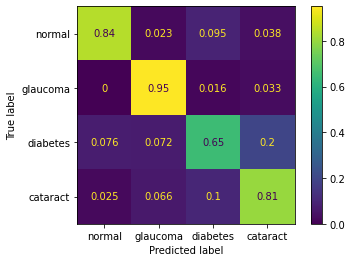

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, classes_x, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=["normal", "glaucoma", "diabetes", "cataract"])
cmd.plot()


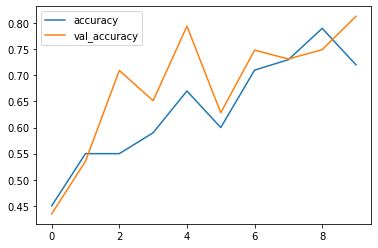

In [ ]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy','val_accuracy']].plot()

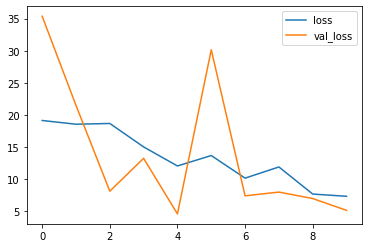

In [ ]:
metrics[['loss','val_loss']].plot()

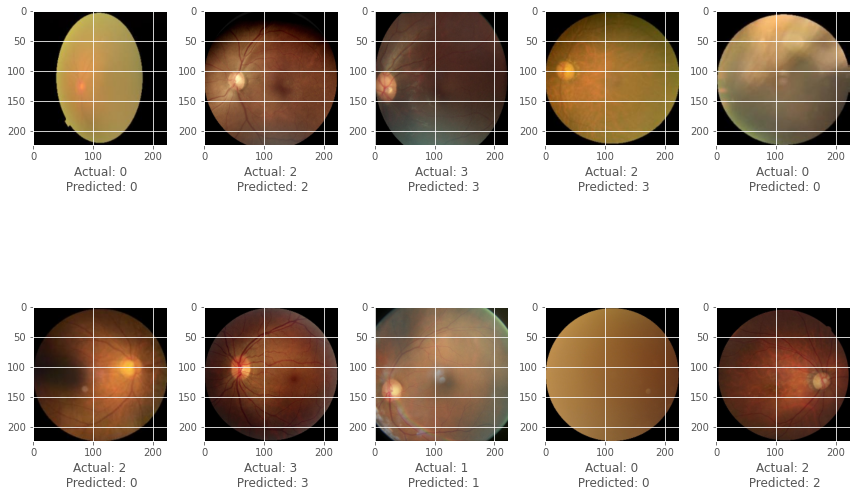

In [ ]:
import random

plt.figure(figsize=(12,9))
plt.style.use("ggplot")
for i in range(10):
    sample = random.choice(range(len(X_test)))
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(X_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {classes_x[sample]}")
    
plt.tight_layout()    
plt.show()  